<a href="https://colab.research.google.com/github/rennydoig/ssc22-case-comp/blob/main/Daisy_dir/The_mixed_effect_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import csv
!pip install geopandas rtree
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pickle
import datetime
!pip install pysal contextily &> /dev/null
!pip install pandana
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily
from pysal.explore import esda
from pysal.lib import weights
drive.mount('/content/drive')

     |████████████████████████████████| 1.0 MB 3.8 MB/s 
     |████████████████████████████████| 1.0 MB 2.0 MB/s 
     |████████████████████████████████| 16.7 MB 7.8 MB/s 
     |████████████████████████████████| 6.3 MB 45.7 MB/s 
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 4.3 MB 35.2 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.7.0
    Uninstalling tables-3.7.0:
      Successfully uninstalled tables-3.7.0


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


Mounted at /content/drive


# The mixed effects model

The mixed effects model Yij = β0 + β1Tij + Vi + ϵij, where
*   Yij: download/upload speed for subject j in cluster i
*   Tij: time (fixed effect)
*   Vi: cluster-specific random effect such that Vi ~ N(0, Σ)
*   ϵij: subject-specific random effect such that eij ~ N(0, σ^2I) 

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
# Residual plot
# performance = pd.DataFrame()
# performance["residuals"] = result.resid.values
# performance["actual"] = data_train['avg_u_mbps']
# performance["fitted"] = result.fittedvalues
# ax = sns.residplot(x = "fitted", y = "residuals", data = performance, lowess=True)
# ax.set(ylabel='residuals')
# plt.show()

def mixedEffctModel(data, formula, random_effect, random_intercept=False, re_formula=None):
  if random_intercept:
    model = smf.mixedlm(formula, data_train, groups=data_train[random_effect], re_formula=re_formula)
    #free = sm.regression.mixed_linear_model.MixedLMParams.from_components(np.ones(2), np.eye(2))
  else: 
    model = smf.mixedlm(formula, data_train, groups=data_train[random_effect])

  result = model.fit()
  print(result.summary())
  return result

def makePrediction(data_test, true, model_fit, random_effect, threshold, random_intercept=False):
  fix_eff_pred = result.predict(exog=data_test)
  
  # The prediction on random effects
  ran_eff_pred = []

  if random_intercept:
    for i in range(data_test.shape[0]):
      x = data_test[random_effect].iloc[i]
      t = data_test['Time'].iloc[i]
      p = result.random_effects[x][0]+t*result.random_effects[x][1]
      ran_eff_pred.append(p)

    # Add the fixed and random effects to get the overall prediction
    pred = fix_eff_pred + ran_eff_pred
  else:
      cd = data_test['CDUID']
      for x in cd:
        # x = data_test[random_effect].iloc[i]
        ran_eff_pred.append(result.random_effects[x])

      # Add the fixed and random effects to get the overall prediction
      pred = fix_eff_pred + np.concatenate(ran_eff_pred)

  # Get RMSE
  print("RMSE: {}".format(np.sqrt(metrics.mean_squared_error(true, pred))))

  # Get accuracy
  pred_class = [int(p >= threshold) for p in pred]
  true_class = [int(p >= threshold) for p in true]
  print("Accuracy: {}".format(accuracy_score(true_class, pred_class, normalize=False)/float(len(true_class))))

  # Get confusion matrix
  print(metrics.confusion_matrix(true_class, pred_class))

  # Get classification report
  print(classification_report(true_class,pred_class))

  # Return prediction results
  data_test['Pred'] = pred
  data_test['Pred_class'] = pred_class
  data_test['True_class'] = true_class
  data_test['Pred_accuracy'] = abs(pred-true)

In [4]:
os.chdir('/content/drive/MyDrive/2022 SSC Case Study/dataset/')
with open('./cd-w-avg-with-dist.p', 'rb') as file:
  df = pickle.load(file)
dat_path = './boundaries/statcan-census-division/statcan-census-division.shp'
boundary_dat = gpd.read_file(dat_path)

69


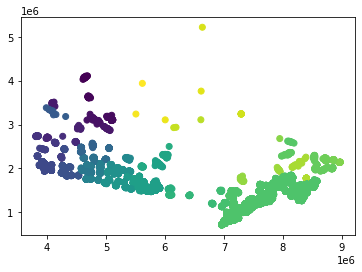

In [5]:
df['x'] = df['geometry'].centroid.x
df['y'] = df['geometry'].centroid.y
coords = df[['x','y']].to_numpy()
eps = 100000
minPoint = 1
dbscan = DBSCAN(eps=eps, min_samples=minPoint) # groups ‘densely grouped’ data points into a single cluster
clusters = dbscan.fit(coords)
labels = pd.Series(clusters.labels_) + 1
labels.index = range(1, len(labels) + 1)
df['GroupID'] = list(labels)
plt.scatter(df['x'], df['y'], c = labels)
print(len(set(labels)))

In [6]:
t_vals = sorted(df['time'].unique()) # sorts year-quarter values
t_ints = [*range(1,len(t_vals)+1)] # creates a list of integers [1, 2, ...]
df['Time'] = df['time'].replace(to_replace=t_vals, value=t_ints)

maxTime = df['Time'].max()
data_train = df[df['Time'] < maxTime] # all the observations except the last one are training set
data_test = df[df['Time'] == maxTime] # the last obseravtion is test set
data_train

,PRUID,CDUID,avg_lat_ms,distance,SACTYPE,DA_POP,devices,tests,geometry,conn_type,time,avg_d_mbps,avg_u_mbps,x,y,GroupID,Time
0,61,6101.0,36.755102,6.425546,8.000000,448.265306,19.0,49.0,"MULTIPOLYGON (((4642490.038 4066985.206, 46426...",fixed,2019-Q1,14.574776,5.991551,4.642066e+06,4.075685e+06,1,1
1,61,6102.0,28.585366,444.526332,8.000000,747.073171,16.0,41.0,"MULTIPOLYGON (((4695765.369 3628102.680, 46958...",fixed,2019-Q1,26.693902,3.160341,4.700584e+06,3.627343e+06,2,1
2,61,6103.0,324.200000,104.673055,8.000000,330.000000,3.0,5.0,"MULTIPOLYGON (((5032382.179 3158440.088, 50322...",fixed,2019-Q1,11.964200,0.841000,5.097810e+06,3.210919e+06,3,1
3,61,6104.0,24.850000,306.145252,8.000000,739.250000,15.0,40.0,"MULTIPOLYGON (((4567677.409 3073390.226, 45678...",fixed,2019-Q1,9.468550,1.158050,4.732215e+06,3.167534e+06,4,1
4,61,6106.0,29.559838,9.110629,3.212982,630.091278,240.0,493.0,"MULTIPOLYGON (((5094536.880 3094447.671, 50944...",fixed,2019-Q1,52.260937,7.403355,5.103739e+06,3.099766e+06,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,62,6204.0,43.071429,0.009375,8.000000,2559.821429,14.0,28.0,"MULTIPOLYGON (((7292387.428 3241679.826, 72921...",mobile,2021-Q1,44.356071,10.217607,7.292616e+06,3.241697e+06,64,9
0,62,6204.0,37.244898,0.058935,8.000000,2660.102041,26.0,49.0,"MULTIPOLYGON (((7292821.313 3241284.005, 72925...",fixed,2021-Q2,12.798102,1.576551,7.293155e+06,3.241727e+06,64,10
0,62,6204.0,22.880000,0.183896,8.000000,2436.100000,17.0,50.0,"MULTIPOLYGON (((7292821.313 3241284.005, 72927...",mobile,2021-Q2,32.714600,7.122600,7.293339e+06,3.241563e+06,64,10
0,62,6204.0,10.702128,0.068872,8.000000,2819.042553,44.0,94.0,"MULTIPOLYGON (((7291442.712 3240472.949, 72916...",fixed,2021-Q3,12.543915,2.334309,7.293034e+06,3.241729e+06,64,11


## Predicting average upload speed
Response: avg_u_mbps \\
Fixed effect: Time + conn_type + devices + DA_POP + distance + SACTYPE + avg_lat_ms  \\
Randome effect: CDUID



In [9]:
result = mixedEffctModel(data_train, 'avg_u_mbps ~ Time + conn_type + devices + DA_POP + distance + SACTYPE + avg_lat_ms + GroupID', 'CDUID')
makePrediction(data_test, data_test['avg_u_mbps'], result, 'CDUID', 10)

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    avg_u_mbps 
No. Observations:    6369       Method:                REML       
No. Groups:          293        Scale:                 169.0462   
Min. group size:     2          Likelihood:            -25774.1708
Max. group size:     22         Converged:             Yes        
Mean group size:     21.7                                         
------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept            32.948    2.874  11.464 0.000  27.315  38.582
conn_type[T.mobile] -18.798    0.349 -53.907 0.000 -19.482 -18.115
Time                  0.917    0.052  17.542 0.000   0.814   1.019
devices               0.000    0.000   4.647 0.000   0.000   0.000
DA_POP                0.001    0.001   0.536 0.592  -0.002   0.003
distance  

Text(0.5, 1.0, 'Upload speed trend over time for CSD=4808')

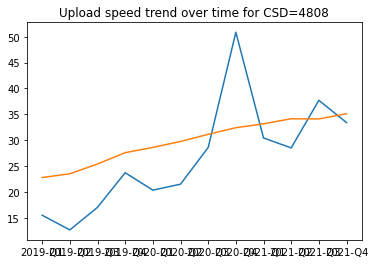

In [10]:
## Take only one CSD (PRUID=48 (Alberta) and conn_type = 'fixed') as an example.
ab_data = df[(df['PRUID'] == 48) & (df['conn_type'] == 'fixed')]
ab_data2 = ab_data[ab_data['CDUID']==4807].sort_values(by='time')
plot_x = ab_data2['time']
plot_y = ab_data2['avg_u_mbps']

fix_eff_pred = result.predict(exog=ab_data2)
ran_eff_pred = []
for i in range(ab_data2.shape[0]):
    x = ab_data2['CDUID'].iloc[i]
    ran_eff_pred.append(result.random_effects[x])
pred = fix_eff_pred + np.concatenate(ran_eff_pred)
ab_data2['pred'] = pred

plt.plot(plot_x, plot_y)
plt.plot(plot_x, ab_data2['pred'])
plt.title('Upload speed trend over time for CSD={csd}'.format(csd = 4808))

In [11]:
boundary_dat['CDUID'] = boundary_dat['CDUID'].astype(int)

data_test_fixed = data_test[data_test['conn_type']=='fixed']
data_test_mobile = data_test[data_test['conn_type']=='mobile']
data_test_fixed.index = range(0, data_test_fixed.shape[0])

col = ['CDUID', 'time', 'GroupID','avg_u_mbps','Pred','Pred_class','True_class','Pred_accuracy']
dat_fixed = pd.merge(data_test_fixed[col], boundary_dat, on='CDUID', how='left')
dat_fixed = gpd.GeoDataFrame(dat_fixed, geometry='geometry', crs="EPSG:4326")

dat_mobile = pd.merge(data_test_mobile[col], boundary_dat, on='CDUID', how='left')
dat_mobile = gpd.GeoDataFrame(dat_mobile, geometry='geometry', crs="EPSG:4326")

### Fixed connection type 


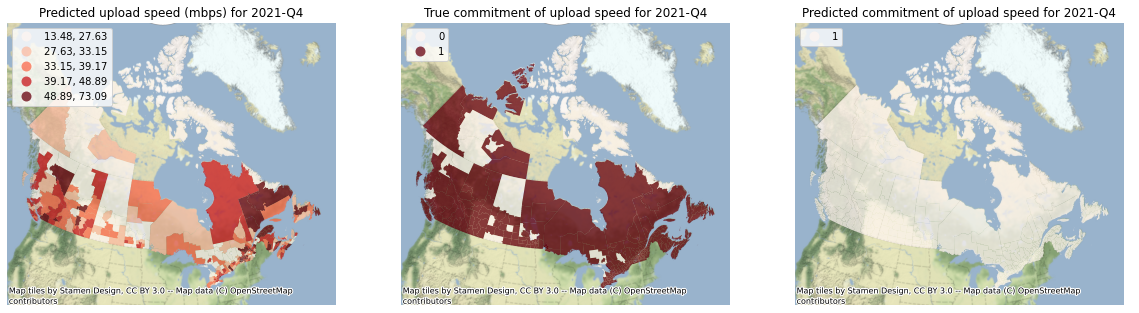

In [15]:
f, axs = plt.subplots(1,3, figsize=(20,15))
[ax1, ax2, ax3] = axs

dat_fixed.plot(column = 'Pred',
             cmap='Reds',
             scheme='quantiles',
             k=5,
             edgecolor='white',
             linewidth=0.,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             ax=ax1)
ax1.set_axis_off()
ax1.set_title("Predicted upload speed (mbps) for 2021-Q4")
contextily.add_basemap(ax1, crs=dat_fixed.crs, source=contextily.providers.Stamen.TerrainBackground)

# dat_fixed.plot(column = 'Pred_accuracy',
#              cmap='Reds',
#              scheme='quantiles',
#              k=5,
#              edgecolor='white',
#              linewidth=0.,
#              alpha=0.75,
#              legend=True,
#              legend_kwds={'loc':2},
#              ax=ax2)
# ax2.set_axis_off()
# ax2.set_title("Prediction accuracy of upload speed for 2021-Q4")
# contextily.add_basemap(ax2, crs=dat_fixed.crs, source=contextily.providers.Stamen.TerrainBackground)

dat_fixed.plot(column = 'True_class',
             cmap='Reds',
             #scheme='quantiles',
             #k=5,
             edgecolor='white',
             linewidth=0.,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             categorical=True,
             ax=ax2)
ax2.set_axis_off()
ax2.set_title("True commitment of upload speed for 2021-Q4")
contextily.add_basemap(ax2, crs=dat_fixed.crs, source=contextily.providers.Stamen.TerrainBackground)

dat_fixed.plot(column = 'Pred_class',
             cmap='Reds',
             #scheme='quantiles',
             #k=5,
             edgecolor='white',
             linewidth=0.,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             categorical=True,
             ax=ax3)
ax3.set_axis_off()
ax3.set_title("Predicted commitment of upload speed for 2021-Q4")
contextily.add_basemap(ax3, crs=dat_fixed.crs, source=contextily.providers.Stamen.TerrainBackground)

### Mobile connection type 

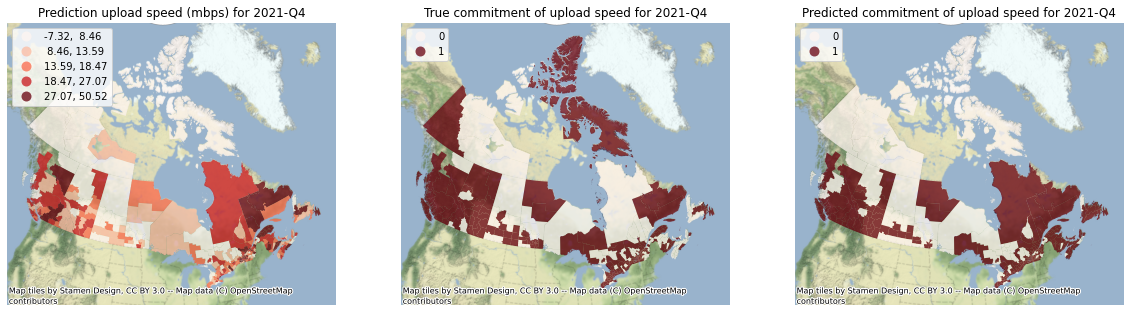

In [16]:
f, axs = plt.subplots(1,3, figsize=(20,15))
[ax1, ax2, ax3] = axs

dat_mobile.plot(column = 'Pred',
             cmap='Reds',
             scheme='quantiles',
             k=5,
             edgecolor='white',
             linewidth=0.,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             ax=ax1)
ax1.set_axis_off()
ax1.set_title("Prediction upload speed (mbps) for 2021-Q4")
contextily.add_basemap(ax1, crs=dat_mobile.crs, source=contextily.providers.Stamen.TerrainBackground)

# dat_mobile.plot(column = 'Pred_accuracy',
#              cmap='Reds',
#              scheme='quantiles',
#              k=5,
#              edgecolor='white',
#              linewidth=0.,
#              alpha=0.75,
#              legend=True,
#              legend_kwds={'loc':2},
#              ax=ax2)
# ax2.set_axis_off()
# ax2.set_title("Prediction accuracy of upload speed (mbps) for 2021-Q4")
# contextily.add_basemap(ax2, crs=dat_mobile.crs, source=contextily.providers.Stamen.TerrainBackground)

dat_mobile.plot(column = 'True_class',
             cmap='Reds',
             #scheme='quantiles',
             #k=5,
             edgecolor='white',
             linewidth=0.,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             categorical=True,
             ax=ax2)
ax2.set_axis_off()
ax2.set_title("True commitment of upload speed for 2021-Q4")
contextily.add_basemap(ax2, crs=dat_mobile.crs, source=contextily.providers.Stamen.TerrainBackground)

dat_mobile.plot(column = 'Pred_class',
             cmap='Reds',
             #scheme='quantiles',
             #k=5,
             edgecolor='white',
             linewidth=0.,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             categorical=True,
             ax=ax3)
ax3.set_axis_off()
ax3.set_title("Predicted commitment of upload speed for 2021-Q4")
contextily.add_basemap(ax3, crs=dat_mobile.crs, source=contextily.providers.Stamen.TerrainBackground)

## Predicting average download speed
Response: avg_d_mbps \\
Fixed effect: Time + conn_type + devices + DA_POP + distance + SACTYPE + avg_lat_ms + GroupID \\
Randome effect: CDUID

In [17]:
result = mixedEffctModel(data_train, 'avg_d_mbps ~ Time + conn_type + devices + DA_POP + distance + SACTYPE + avg_lat_ms + GroupID', 'CDUID')
makePrediction(data_test, data_test['avg_d_mbps'], result, 'CDUID', 50)

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    avg_d_mbps 
No. Observations:    6369       Method:                REML       
No. Groups:          293        Scale:                 435.5076   
Min. group size:     2          Likelihood:            -28817.0952
Max. group size:     22         Converged:             Yes        
Mean group size:     21.7                                         
------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept            94.099    5.032  18.700 0.000  84.236 103.962
conn_type[T.mobile] -13.736    0.561 -24.473 0.000 -14.836 -12.636
Time                  3.303    0.084  39.377 0.000   3.139   3.468
devices               0.000    0.000   5.376 0.000   0.000   0.001
DA_POP                0.008    0.002   4.114 0.000   0.004   0.012
distance  

Text(0.5, 1.0, 'Download speed trend over time for CSD=4808')

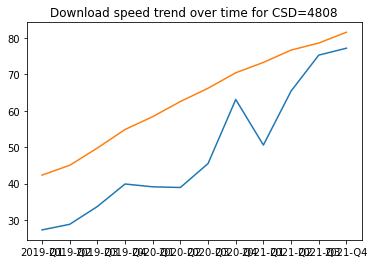

In [18]:
## Take only one CSD (PRUID=48 (Alberta) and conn_type = 'fixed') as an example.
ab_data = df[(df['PRUID'] == 48) & (df['conn_type'] == 'fixed')]
ab_data2 = ab_data[ab_data['CDUID']==4807].sort_values(by='time')
plot_x = ab_data2['time']
plot_y = ab_data2['avg_d_mbps']

fix_eff_pred = result.predict(exog=ab_data2)
ran_eff_pred = []
for i in range(ab_data2.shape[0]):
    x = ab_data2['CDUID'].iloc[i]
    ran_eff_pred.append(result.random_effects[x])
pred = fix_eff_pred + np.concatenate(ran_eff_pred)
ab_data2['pred'] = pred

plt.plot(plot_x, plot_y)
plt.plot(ab_data2['time'], ab_data2['pred'])
plt.title('Download speed trend over time for CSD={csd}'.format(csd = 4808))

In [19]:
data_test_fixed = data_test[data_test['conn_type']=='fixed']
data_test_mobile = data_test[data_test['conn_type']=='mobile']
data_test_fixed.index = range(0, data_test_fixed.shape[0])

col = ['CDUID', 'time', 'GroupID','avg_u_mbps','Pred','Pred_class','True_class','Pred_accuracy']
dat_fixed = pd.merge(data_test_fixed[col], boundary_dat, on='CDUID', how='left')
dat_fixed = gpd.GeoDataFrame(dat_fixed, geometry='geometry', crs="EPSG:4326")

dat_mobile = pd.merge(data_test_mobile[col], boundary_dat, on='CDUID', how='left')
dat_mobile = gpd.GeoDataFrame(dat_mobile, geometry='geometry', crs="EPSG:4326")

### Fixed connection type

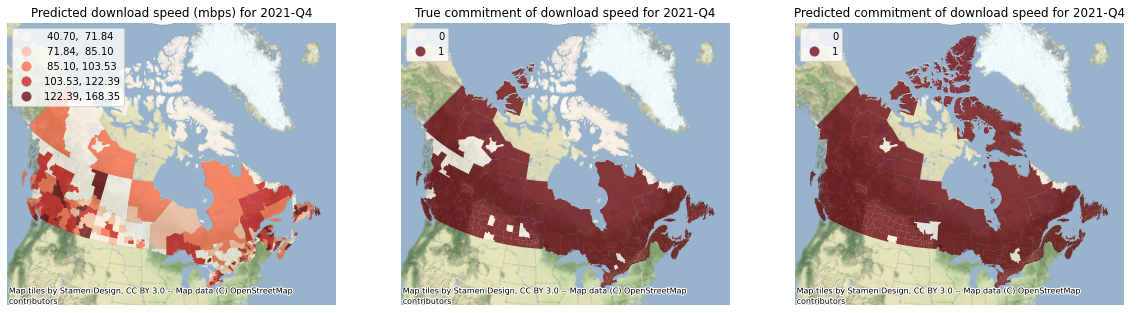

In [20]:
f, axs = plt.subplots(1,3, figsize=(20,15))
[ax1, ax2, ax3] = axs

dat_fixed.plot(column = 'Pred',
             cmap='Reds',
             scheme='quantiles',
             k=5,
             edgecolor='white',
             linewidth=0.,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             ax=ax1)
ax1.set_axis_off()
ax1.set_title("Predicted download speed (mbps) for 2021-Q4")
contextily.add_basemap(ax1, crs=dat_fixed.crs, source=contextily.providers.Stamen.TerrainBackground)

# dat_fixed.plot(column = 'Pred_accuracy',
#              cmap='Reds',
#              scheme='quantiles',
#              k=5,
#              edgecolor='white',
#              linewidth=0.,
#              alpha=0.75,
#              legend=True,
#              legend_kwds={'loc':2},
#              ax=ax2)
# ax2.set_axis_off()
# ax2.set_title("Prediction accuracy of download speed for 2021-Q4")
# contextily.add_basemap(ax2, crs=dat_fixed.crs, source=contextily.providers.Stamen.TerrainBackground)

dat_fixed.plot(column = 'True_class',
             cmap='Reds',
             #scheme='quantiles',
             #k=5,
             edgecolor='white',
             linewidth=0.,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             categorical=True,
             ax=ax2)
ax2.set_axis_off()
ax2.set_title("True commitment of download speed for 2021-Q4")
contextily.add_basemap(ax2, crs=dat_fixed.crs, source=contextily.providers.Stamen.TerrainBackground)

dat_fixed.plot(column = 'Pred_class',
             cmap='Reds',
             #scheme='quantiles',
             #k=5,
             edgecolor='white',
             linewidth=0.,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             categorical=True,
             ax=ax3)
ax3.set_axis_off()
ax3.set_title("Predicted commitment of download speed for 2021-Q4")
contextily.add_basemap(ax3, crs=dat_fixed.crs, source=contextily.providers.Stamen.TerrainBackground)

### Mobile connection type

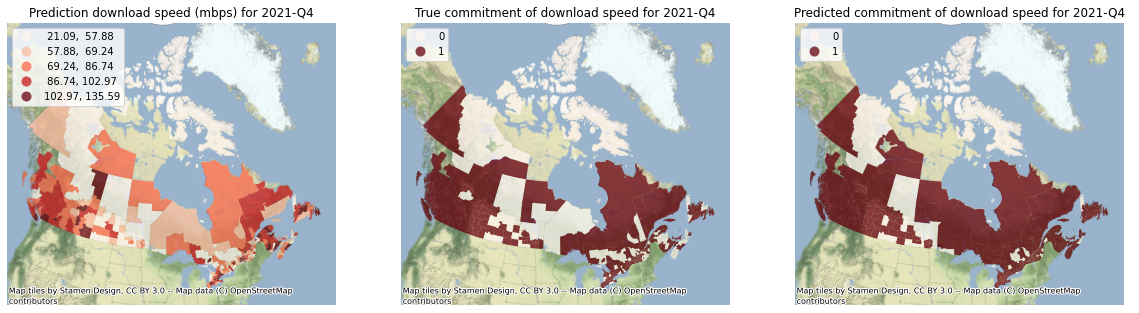

In [21]:
f, axs = plt.subplots(1,3, figsize=(20,15))
[ax1, ax2, ax3] = axs

dat_mobile.plot(column = 'Pred',
             cmap='Reds',
             scheme='quantiles',
             k=5,
             edgecolor='white',
             linewidth=0.,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             ax=ax1)
ax1.set_axis_off()
ax1.set_title("Prediction download speed (mbps) for 2021-Q4")
contextily.add_basemap(ax1, crs=dat_mobile.crs, source=contextily.providers.Stamen.TerrainBackground)

# dat_mobile.plot(column = 'Pred_accuracy',
#              cmap='Reds',
#              scheme='quantiles',
#              k=5,
#              edgecolor='white',
#              linewidth=0.,
#              alpha=0.75,
#              legend=True,
#              legend_kwds={'loc':2},
#              ax=ax2)
# ax2.set_axis_off()
# ax2.set_title("Prediction accuracy of download speed (mbps) for 2021-Q4")
# contextily.add_basemap(ax2, crs=dat_mobile.crs, source=contextily.providers.Stamen.TerrainBackground)

dat_mobile.plot(column = 'True_class',
             cmap='Reds',
             #scheme='quantiles',
             #k=5,
             edgecolor='white',
             linewidth=0.,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             categorical=True,
             ax=ax2)
ax2.set_axis_off()
ax2.set_title("True commitment of download speed for 2021-Q4")
contextily.add_basemap(ax2, crs=dat_mobile.crs, source=contextily.providers.Stamen.TerrainBackground)

dat_mobile.plot(column = 'Pred_class',
             cmap='Reds',
             #scheme='quantiles',
             #k=5,
             edgecolor='white',
             linewidth=0.,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             categorical=True,
             ax=ax3)
ax3.set_axis_off()
ax3.set_title("Predicted commitment of download speed for 2021-Q4")
contextily.add_basemap(ax3, crs=dat_mobile.crs, source=contextily.providers.Stamen.TerrainBackground)